https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
import seaborn as sns
import matplotlib as plt
import altair as alt
import plotly.express as px
from pyspark.sql.functions import column
from geopy.geocoders import Nominatim

In [3]:
df_path = r"F:\Datasets\CSV datasets\credit_card_transactions.csv"

In [4]:
spark = SparkSession.builder.appName('Credit_Card_Transactions').getOrCreate()

In [5]:
df = spark.read.csv(df_path, inferSchema=True, header=True)

In [6]:
df = df.withColumnRenamed('Unnamed: 0', 'user_id')

In [7]:
df.select([
    F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in df.columns
]).show()

+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|user_id|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|merch_zipcode|
+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|      0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|       195973|
+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+



In [8]:
df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)



In [9]:
df.show()

+-------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+
|user_id|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|
+-------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-

In [10]:
df.select(
    F.min(F.col('trans_date_trans_time')).alias('min_date'),
    F.max(F.col('trans_date_trans_time')).alias('max_date'),
).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2019-01-01 00:00:18|2020-06-21 12:13:37|
+-------------------+-------------------+



In [11]:
df.agg(
    F.min("trans_date_trans_time").alias("min_date"),
    F.max("trans_date_trans_time").alias("max_date"),
    (F.unix_timestamp(F.max("trans_date_trans_time")) - F.unix_timestamp(F.min("trans_date_trans_time"))).alias(
        "time_diff_seconds")
).show()

+-------------------+-------------------+-----------------+
|           min_date|           max_date|time_diff_seconds|
+-------------------+-------------------+-----------------+
|2019-01-01 00:00:18|2020-06-21 12:13:37|         46437199|
+-------------------+-------------------+-----------------+



In [12]:
df = df.withColumn(
    'age',
    F.round((
        F.months_between(F.current_date(), F.col('dob')) / 12), 0)
        .cast(IntegerType()).alias('age')
)

In [13]:
df.show()

+-------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+---+
|user_id|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|age|
+-------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--

In [14]:
{index: column for index, column in enumerate(df.columns)}

{0: 'user_id',
 1: 'trans_date_trans_time',
 2: 'cc_num',
 3: 'merchant',
 4: 'category',
 5: 'amt',
 6: 'first',
 7: 'last',
 8: 'gender',
 9: 'street',
 10: 'city',
 11: 'state',
 12: 'zip',
 13: 'lat',
 14: 'long',
 15: 'city_pop',
 16: 'job',
 17: 'dob',
 18: 'trans_num',
 19: 'unix_time',
 20: 'merch_lat',
 21: 'merch_long',
 22: 'is_fraud',
 23: 'merch_zipcode',
 24: 'age'}

In [15]:
gender_avg_age = df.groupBy(
    F.col('gender')
).agg(
    F.round(F.mean('age')).alias('avg_age')
)

<Axes: xlabel='gender', ylabel='avg_age'>

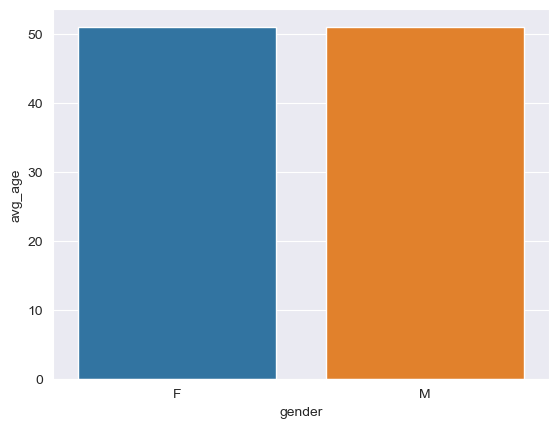

In [16]:
sns.barplot(gender_avg_age.toPandas(), x='gender', y='avg_age', hue='gender')

In [17]:
df.show(5, truncate=False)

+-------+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+----------+------------------+-----------+--------+-------------+---+
|user_id|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last   |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |unix_time |merch_lat         |merch_long |is_fraud|merch_zipcode|age|
+-------+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+-----------------------

In [18]:
df.select([
    F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in df.columns]).show()

+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+
|user_id|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|merch_zipcode|age|
+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+
|      0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|       195973|  0|
+-------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+



In [19]:
df = df.fillna({
    'amt': 0,
    'zip': 0,
    'city': 'Unknown',
    'merch_zipcode': 0,
})

In [20]:
from pyspark.sql.types import DateType, TimestampType

In [21]:
df = df.withColumns({
    'trans_date_trans_time': F.col('trans_date_trans_time').cast(TimestampType()),
    'dob': F.col('dob').cast(DateType())
})

In [22]:
df.groupBy('trans_num', 'unix_time').count().filter(
    F.col('count') > 1
).show(truncate=False)

+---------+---------+-----+
|trans_num|unix_time|count|
+---------+---------+-----+
+---------+---------+-----+



In [23]:
df = df.withColumn(
    'cc_num_masked',
    F.concat(F.lit('*********'), F.substring('cc_num', -4, 4))
)

In [24]:
df = df.withColumns({
    'year': F.year(F.col('trans_date_trans_time')),
    'month': F.month(F.col('trans_date_trans_time')),
})

In [25]:
for col in df.columns:
    if col in ['merchant', 'category', 'state', 'job']:
        df = df.withColumn(col, F.trim(F.lower(F.col(col))))

In [26]:
df = df.withColumn(
    'day_of_week',
    F.when(F.dayofweek(F.col('trans_date_trans_time')) == 1, 'Monday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 2, 'Tuesday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 3, 'Wednesday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 4, 'Thursday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 5, 'Friday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 6, 'Saturday')
     .when(F.dayofweek(F.col('trans_date_trans_time')) == 7, 'Sunday')
     .otherwise('Unknown')
)

In [27]:
df = df.withColumn(
    'calculated_age',
    F.floor(F.datediff(F.col('trans_date_trans_time'), F.col('dob')) / 365.25)
)

In [28]:
window_spec = Window.orderBy(F.col('amt'))

df = df.withColumn(
    'percent_rank', F.percent_rank().over(window_spec)
)

In [29]:
quantiles = df.approxQuantile('amt', [0.33, 0.66], 0.01)

df = df.withColumn(
    'amount_category',
    F.when(F.col('amt') <= quantiles[0], 'small')
    .when((F.col('amt') > quantiles[0]) & (F.col('amt') <= quantiles[1]), 'medium')
    .otherwise('large')
)

In [30]:
df = df.withColumn('hour', F.hour(F.col('trans_date_trans_time'))) \
    .withColumn('minute', F.minute(F.col('trans_date_trans_time'))) \
    .withColumn('second', F.second(F.col('trans_date_trans_time')))

In [32]:
R = 6371

df = df.withColumn(
    "distance_km",
    2 * R * F.asin(F.sqrt(
        F.sin(F.radians(F.col("merch_lat") - F.col("lat")) / 2) ** 2 +
        F.cos(F.radians(F.col("lat"))) * F.cos(F.radians(F.col("merch_lat"))) *
        F.sin(F.radians(F.col("merch_long") - F.col("long")) / 2) ** 2
    ))
)

In [33]:
high_risk_jobs = [
    "Futures Trader",
    "Equities Trader",
    "Petroleum Engineer",
    "Armed Forces Training and Education Officer",
    "Hospital Doctor",
    "Drilling Engineer",
    "Mining Engineer",
    "Surgeon",
    "Police Officer",
    "Airline Pilot",
    "Firefighter",
    "Paramedic",
    "Construction Site Engineer",
    "Veterinary Surgeon",
    "Forensic Psychologist",
    "Tree Surgeon",
    "Armed Forces Logistics/Support/Administrative Officer",
    "Geologist, Wellsite",
    "Aeronautical Engineer",
    "Clinical Research Associate",
    "Health Physicist",
    "Surveyor, Mining",
    "Operations Geologist",
    "Seismic Interpreter",
    "Acupuncturist"
]

In [34]:
df = df.withColumn(
    'high_risk_job',
    F.when(F.col('job').isin(high_risk_jobs), F.lit('High Risk')).otherwise(F.lit('Low Risk'))
)

In [35]:
df.show(5, truncate=False)

+-------+---------------------+-------------------+-------------------------------------+------------+---+-----------+---------+------+------------------------------+------------------------+-----+-----+-------+---------+--------+--------------------------+----------+--------------------------------+----------+---------+-----------+--------+-------------+---+-------------+----+-----+-----------+--------------+------------+---------------+----+------+------+------------------+-------------+
|user_id|trans_date_trans_time|cc_num             |merchant                             |category    |amt|first      |last     |gender|street                        |city                    |state|zip  |lat    |long     |city_pop|job                       |dob       |trans_num                       |unix_time |merch_lat|merch_long |is_fraud|merch_zipcode|age|cc_num_masked|year|month|day_of_week|calculated_age|percent_rank|amount_category|hour|minute|second|distance_km       |high_risk_job|
+-------+-

In [36]:
df.groupBy('day_of_week', 'cc_num').count().orderBy('count', ascending=False).show()

+-----------+-------------------+-----+
|day_of_week|             cc_num|count|
+-----------+-------------------+-----+
|     Monday|    372520049757633|  782|
|     Monday|     30273037698427|  773|
|     Monday|   3545109339866548|  768|
|     Monday|   2720433095629877|  765|
|     Monday|   4364010865167176|  761|
|     Monday|      4745996322265|  746|
|     Monday|   6534628260579800|  745|
|     Monday|4587657402165341815|  737|
|     Monday|   6538441737335434|  734|
|     Monday|   2242542703101233|  728|
|     Monday|   4586810168620942|  724|
|    Tuesday|   2720433095629877|  688|
|     Monday|   3533742182628021|  684|
|    Tuesday|   6534628260579800|  680|
|    Tuesday|   3545109339866548|  678|
|     Monday|   6011693194885790|  675|
|    Tuesday|   4364010865167176|  666|
|     Monday|     38052002992326|  660|
|     Monday|   4653879239169997|  656|
|     Monday|   2264937662466770|  651|
+-----------+-------------------+-----+
only showing top 20 rows



In [37]:
df.withColumn(
    'date', F.to_date('trans_date_trans_time')
).groupBy(
    'date', 'cc_num'
).count(
).orderBy(
    'count', ascending=False
).show()

+----------+-------------------+-----+
|      date|             cc_num|count|
+----------+-------------------+-----+
|2019-12-15|   3556613125071656|   34|
|2019-12-08|   4586810168620942|   33|
|2019-12-15|   4364010865167176|   30|
|2019-12-08|   3545109339866548|   28|
|2019-12-08|   6534628260579800|   28|
|2019-12-01|   4364010865167176|   26|
|2019-12-29|   4653879239169997|   26|
|2019-12-08|4587657402165341815|   26|
|2019-12-08|   3551217896304745|   26|
|2019-12-29|   3556613125071656|   25|
|2019-12-29|   4836998673805450|   25|
|2019-12-15|      4745996322265|   25|
|2020-06-15|      4745996322265|   25|
|2019-12-07|    213112402583773|   24|
|2019-12-08|   3533742182628021|   24|
|2019-12-02|   4939976756738216|   24|
|2019-12-08|   2720433095629877|   24|
|2019-12-01|   3567697931646329|   24|
|2019-12-15|4587657402165341815|   24|
|2019-12-09|   6011438889172900|   24|
+----------+-------------------+-----+
only showing top 20 rows



In [38]:
df.show()

+-------+---------------------+-------------------+--------------------+--------------+---+-----------+----------+------+--------------------+--------------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+---+-------------+----+-----+-----------+--------------+------------+---------------+----+------+------+------------------+-------------+
|user_id|trans_date_trans_time|             cc_num|            merchant|      category|amt|      first|      last|gender|              street|                city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|age|cc_num_masked|year|month|day_of_week|calculated_age|percent_rank|amount_category|hour|minute|second|       distance_km|high_risk_job|
+-------+---------------------+-------------------+-------------------

In [39]:
rolling_avg_window = (Window
    .partitionBy('user_id')
    .orderBy(F.col('trans_date_trans_time'))
    .rowsBetween(-6, 0)
)


df.withColumn(
    'rolling_avg_amt',
    F.avg('amt').over(rolling_avg_window)
).show()

+-------+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+---+-------------+----+-----+-----------+--------------+-------------------+---------------+----+------+------+------------------+-------------+---------------+
|user_id|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|age|cc_num_masked|year|month|day_of_week|calculated_age|       percent_rank|amount_category|hour|minute|second|       distance_km|high_risk_job|rolling_avg_amt|
+---

In [41]:
df = df.withColumn("transaction_date", F.to_date(F.col("trans_date_trans_time")))

user_summary = df.groupBy('user_id').agg(
    F.sum('amt').alias('total_transaction_value'),
    F.min('transaction_date').alias('first_transaction_date'),
    F.max('transaction_date').alias('last_transaction_date'),
)

user_summary = user_summary.withColumn(
    "active_days",
    F.datediff(F.col("last_transaction_date"), F.col("first_transaction_date")) + 1
)

user_summary = user_summary.withColumn(
    "ltv",
    F.round(F.col("total_transaction_value") / F.col("active_days"), 2)
)

user_summary.show()

+-------+-----------------------+----------------------+---------------------+-----------+------+
|user_id|total_transaction_value|first_transaction_date|last_transaction_date|active_days|   ltv|
+-------+-----------------------+----------------------+---------------------+-----------+------+
|    148|                  32.82|            2019-01-01|           2019-01-01|          1| 32.82|
|    463|                  15.44|            2019-01-01|           2019-01-01|          1| 15.44|
|    471|                 107.69|            2019-01-01|           2019-01-01|          1|107.69|
|    496|                 168.42|            2019-01-01|           2019-01-01|          1|168.42|
|    833|                  93.84|            2019-01-01|           2019-01-01|          1| 93.84|
|   1088|                  23.95|            2019-01-01|           2019-01-01|          1| 23.95|
|   1238|                   6.56|            2019-01-01|           2019-01-01|          1|  6.56|
|   1342|           